In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

%matplotlib inline

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

In [2]:
class PairedSlotMachineEnv(gym.Env):
    def __init__(self):
        super(PairedSlotMachineEnv, self).__init__()

        # Define action space: pick option 1 or option 2 in the current pair
        self.action_space = spaces.Discrete(2)
        
        # Observation space: represent each machine with its index and indicator status (0 or 1)
        self.observation_space = spaces.MultiDiscrete([8, 2, 8, 2])

        # Define slot machine points and probabilities
        self.points = {
            'A': 10, 'B': 10, 'C': 1, 'D': 1,
            'E': 10, 'F': 10, 'G': 1, 'H': 1
        }
        self.probabilities = {
            'A': 0.75, 'B': 0.25, 'C': 0.75, 'D': 0.25,
            'E': 0.75, 'F': 0.25, 'G': 0.75, 'H': 0.25
        }

        # Original pairs for Learning Phase and new pairs for Transfer Phase
        self.learning_pairs = [('A', 'B'), ('C', 'D'), ('E', 'F'), ('G', 'H')]
        self.transfer_pairs = [('A', 'C'), ('B', 'D'), ('E', 'H'), ('F', 'G')]
        self.transfer_phase = False  # Start in learning phase by default
        self.current_pair = None
        self.rewards = None
        self.indicators = None

        # Initialize logs to track each action taken by the agent
        self.logs = []

    def set_transfer_phase(self, transfer: bool):
        """Toggle between learning and transfer phases."""
        self.transfer_phase = transfer

    def reset(self, seed=None):
        super().reset(seed=seed)
        # Start with a random pair from the current phase
        self.current_pair = self._get_random_pair()
        # Set up the initial observation with pre-sampled rewards and indicators
        return self._get_observation(), {}

    def _get_machine_index(self, machine):
        # Map machine labels to indices for the observation space
        machine_indices = {'A': 0, 'B': 1, 'C': 2, 'D': 3,
                           'E': 4, 'F': 5, 'G': 6, 'H': 7}
        return machine_indices[machine]

    def _get_random_pair(self):
        # Select from learning pairs or transfer pairs based on the phase
        pairs = self.transfer_pairs if self.transfer_phase else self.learning_pairs
        pair = pairs[np.random.randint(len(pairs))]
        # Randomly shuffle the order with 50% probability
        if np.random.rand() < 0.5:
            pair = pair[::-1]
        return pair

    def _get_indicator_status(self, machine, reward_given):
        # 95% chance of showing the indicator if reward is given, or hiding it if not
        if reward_given:
            return 1 if np.random.rand() < 0.95 else 0
        else:
            return 0 if np.random.rand() < 0.95 else 1

    def _get_observation(self):
        # Generate machine indices for the current pair
        machine_indices = [self._get_machine_index(m) for m in self.current_pair]

        # Sample rewards and indicator statuses once, store them in instance variables
        self.rewards = []
        self.indicators = []
        
        for i, machine in enumerate(self.current_pair):
            reward_given = np.random.rand() < self.probabilities[machine]
            reward = self.points[machine] if reward_given else 0
            self.rewards.append(reward)
            indicator = self._get_indicator_status(machine, reward_given)
            self.indicators.append(indicator)

        # Return observation as [machine index, indicator] pairs
        return np.array([machine_indices[0], self.indicators[0], machine_indices[1], self.indicators[1]])

    def step(self, action):
        # Use the pre-sampled reward for the selected action
        reward = self.rewards[action]
        
        # Log the outcome in the desired format
        log_entry = {
            'pair': ''.join(self.current_pair),
            'lSymbol': self.current_pair[0],
            'rSymbol': self.current_pair[1],
            'lIndicator': bool(self.indicators[0]),
            'rIndicator': bool(self.indicators[1]),
            'symbolPicked': self.current_pair[action]
        }
        self.logs.append(log_entry)
        
        # Select a new random pair for the next step
        self.current_pair = self._get_random_pair()
        
        # Get the new observation (with updated pre-sampled rewards and indicators)
        observation = self._get_observation()
        return observation, reward, False, False, {}

    def render(self):
        print(f"Current pair: {self.current_pair[0]} (with indicator {self.indicators[0]}) "
              f"vs {self.current_pair[1]} (with indicator {self.indicators[1]})")

    def get_logs(self):
        # Return the full log for analysis
        return self.logs


In [3]:
def plot_choices_over_time(df, pair, lSymbol, rSymbol):
    # Filter data for the specific pair and both positions
    pair_df = df[(df['pair'] == pair)]

    # Iterate over all indicator combinations
    indicator_combinations = pair_df[['lIndicator', 'rIndicator']].drop_duplicates()

    for _, comb in indicator_combinations.iterrows():
        l_ind = comb['lIndicator']
        r_ind = comb['rIndicator']
        
        # Filter for the specific indicator combination
        subset = pair_df[(pair_df['lIndicator'] == l_ind) & (pair_df['rIndicator'] == r_ind)]

        # Calculate cumulative counts for each symbol
        subset['time'] = range(len(subset))  # Add a time step column
        cumulative_counts = subset.groupby('time')['symbolPicked'].value_counts().unstack(fill_value=0).cumsum()

        # Plot the cumulative counts
        plt.figure(figsize=(10, 6))
        for symbol in [lSymbol, rSymbol]:
            plt.plot(cumulative_counts.index, cumulative_counts[symbol], label=f'Symbol {symbol}')

        # Add labels, title, and legend
        plt.title(f"Choices over Time for Pair {pair} (lIndicator={l_ind}, rIndicator={r_ind})")
        plt.xlabel("Time Step")
        plt.ylabel("Cumulative Count of Choices")
        plt.legend()
        plt.grid()
        plt.show()
        plt.close()  # Ensure the plot does not overlap in Jupyter

In [4]:
# Initialize the environment
env = PairedSlotMachineEnv()
check_env(env)

# Create the PPO model
model = PPO("MlpPolicy", env, verbose=1, gamma=1)

# Train the model
model.learn(total_timesteps=200000)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 361  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 262         |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009387325 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | 0.00214     |
|    learning_rate        | 0.0003      |
|    loss                 | 987         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0181     |
|    value_loss        

200715
  pair lSymbol rSymbol  lIndicator  rIndicator symbolPicked
0   HG       H       G       False        True            H
1   HG       H       G       False        True            G
2   BA       B       A       False        True            A
3   EF       E       F       False        True            F
4   BA       B       A       False        True            B
5   EF       E       F        True        True            F
6   HG       H       G       False        True            G
7   BA       B       A        True        True            B
8   HG       H       G        True       False            G
9   DC       D       C       False        True            C


C:\Users\Prod\AppData\Local\Temp\ipykernel_2660\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


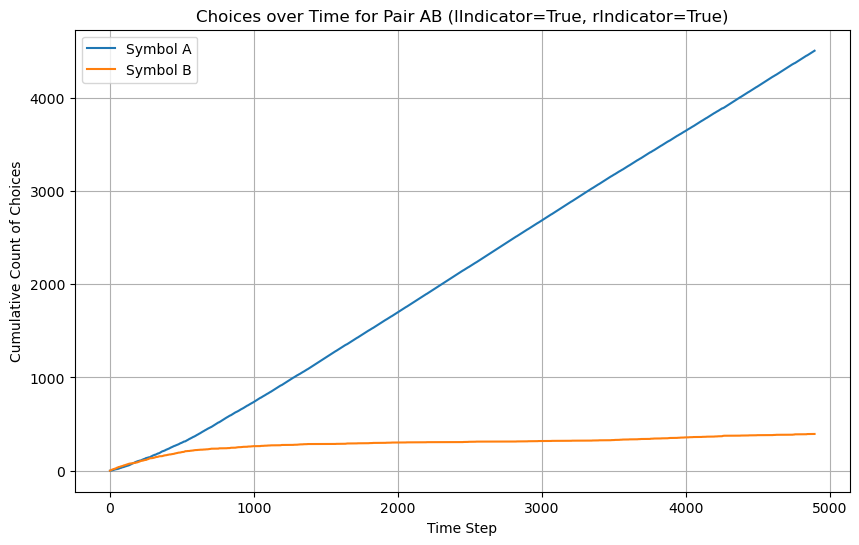

C:\Users\Prod\AppData\Local\Temp\ipykernel_2660\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


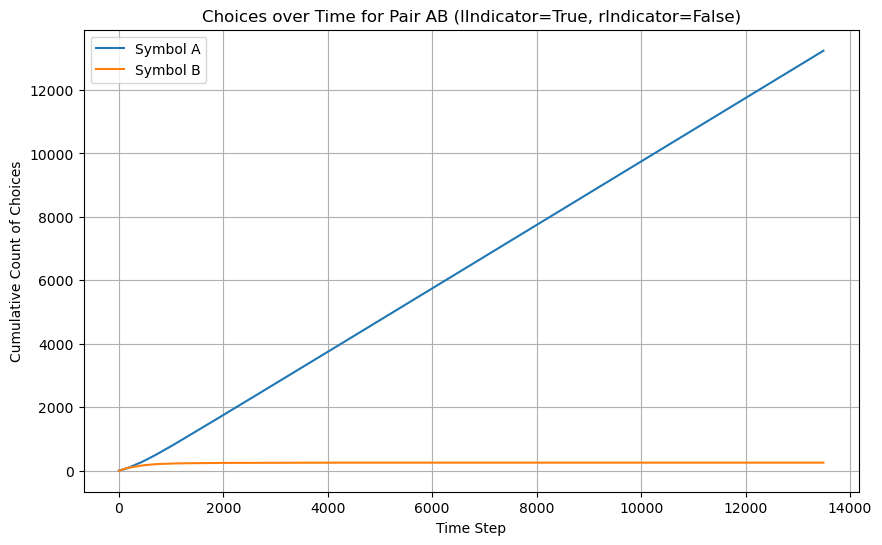

C:\Users\Prod\AppData\Local\Temp\ipykernel_2660\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


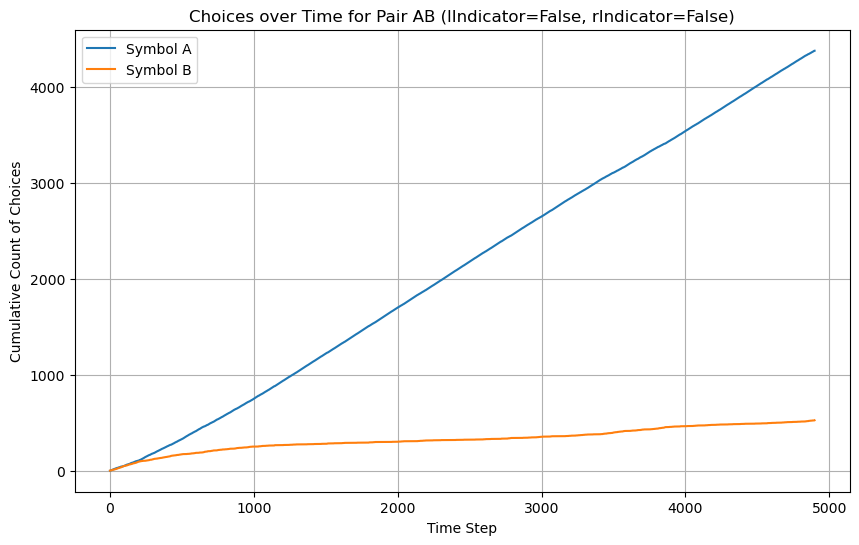

C:\Users\Prod\AppData\Local\Temp\ipykernel_2660\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


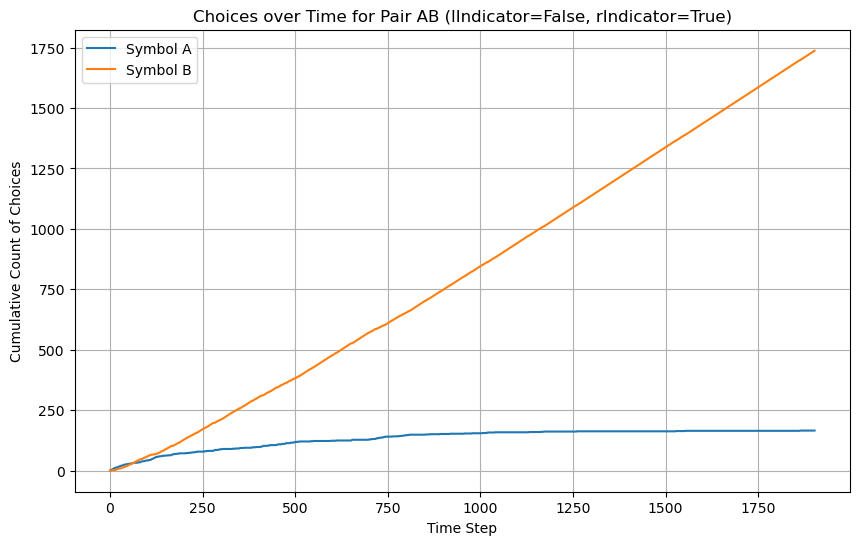

C:\Users\Prod\AppData\Local\Temp\ipykernel_2660\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


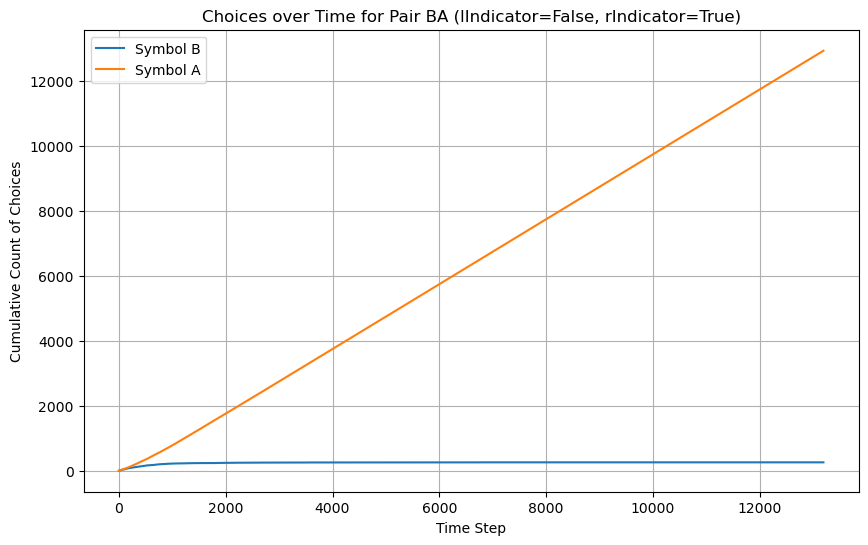

C:\Users\Prod\AppData\Local\Temp\ipykernel_2660\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


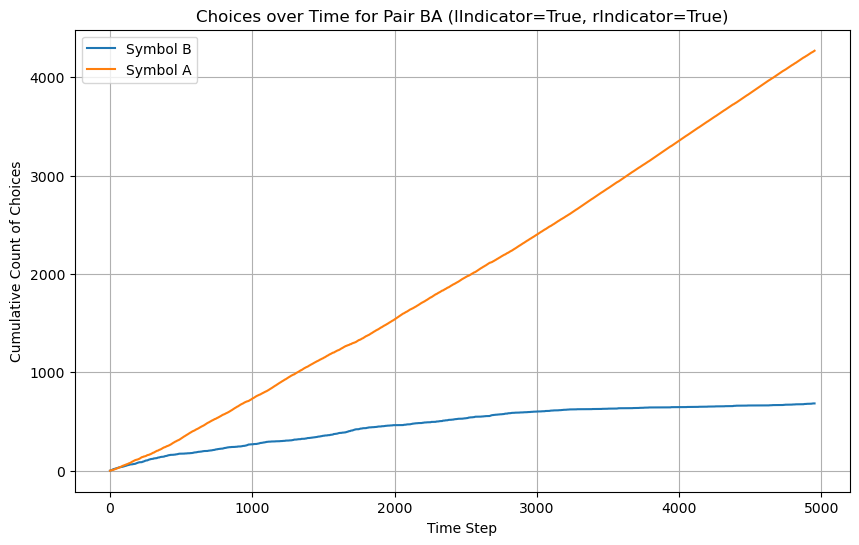

C:\Users\Prod\AppData\Local\Temp\ipykernel_2660\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


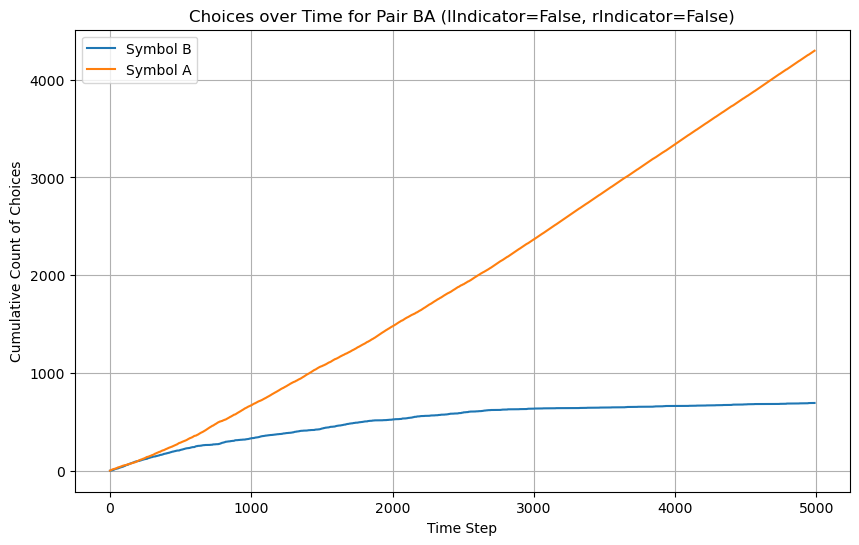

C:\Users\Prod\AppData\Local\Temp\ipykernel_2660\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


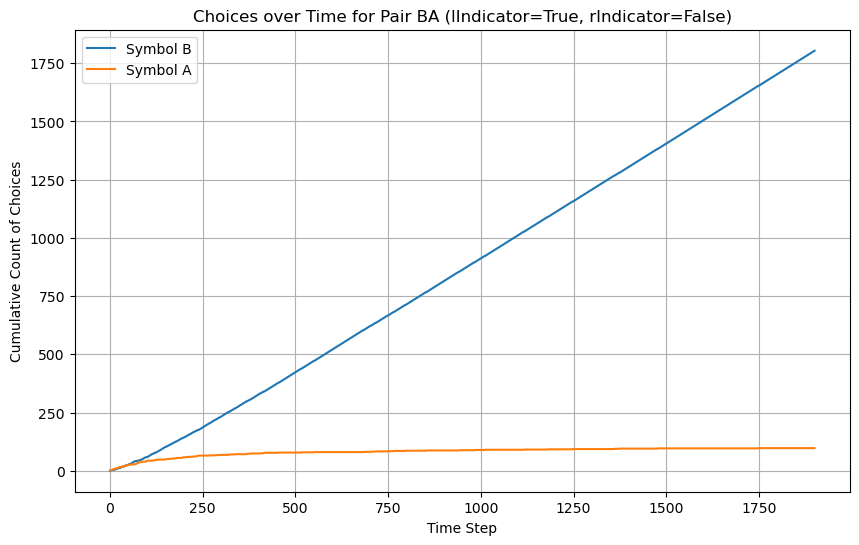

In [5]:
logs = env.get_logs()
logs = pd.DataFrame(logs)
print(len(logs))
print(logs.iloc[0:10])

# Plot choices for pair 'AB' where A and B switch positions
plot_choices_over_time(logs, pair='AB', lSymbol='A', rSymbol='B')
plot_choices_over_time(logs, pair='BA', lSymbol='B', rSymbol='A')

In [6]:
# Count the number of times each pair showed up in each configuration
pair_config_counts = logs.groupby(['pair', 'lSymbol', 'rSymbol', 'lIndicator', 'rIndicator']).size().reset_index(name='count')

# Display the results
print(pair_config_counts)


   pair lSymbol rSymbol  lIndicator  rIndicator  count
0    AB       A       B       False       False   4899
1    AB       A       B       False        True   1903
2    AB       A       B        True       False  13491
3    AB       A       B        True        True   4896
4    BA       B       A       False       False   4989
5    BA       B       A       False        True  13190
6    BA       B       A        True       False   1901
7    BA       B       A        True        True   4953
8    CD       C       D       False       False   5015
9    CD       C       D       False        True   1932
10   CD       C       D        True       False  13154
11   CD       C       D        True        True   5115
12   DC       D       C       False       False   5045
13   DC       D       C       False        True  13180
14   DC       D       C        True       False   1907
15   DC       D       C        True        True   4982
16   EF       E       F       False       False   4940
17   EF   

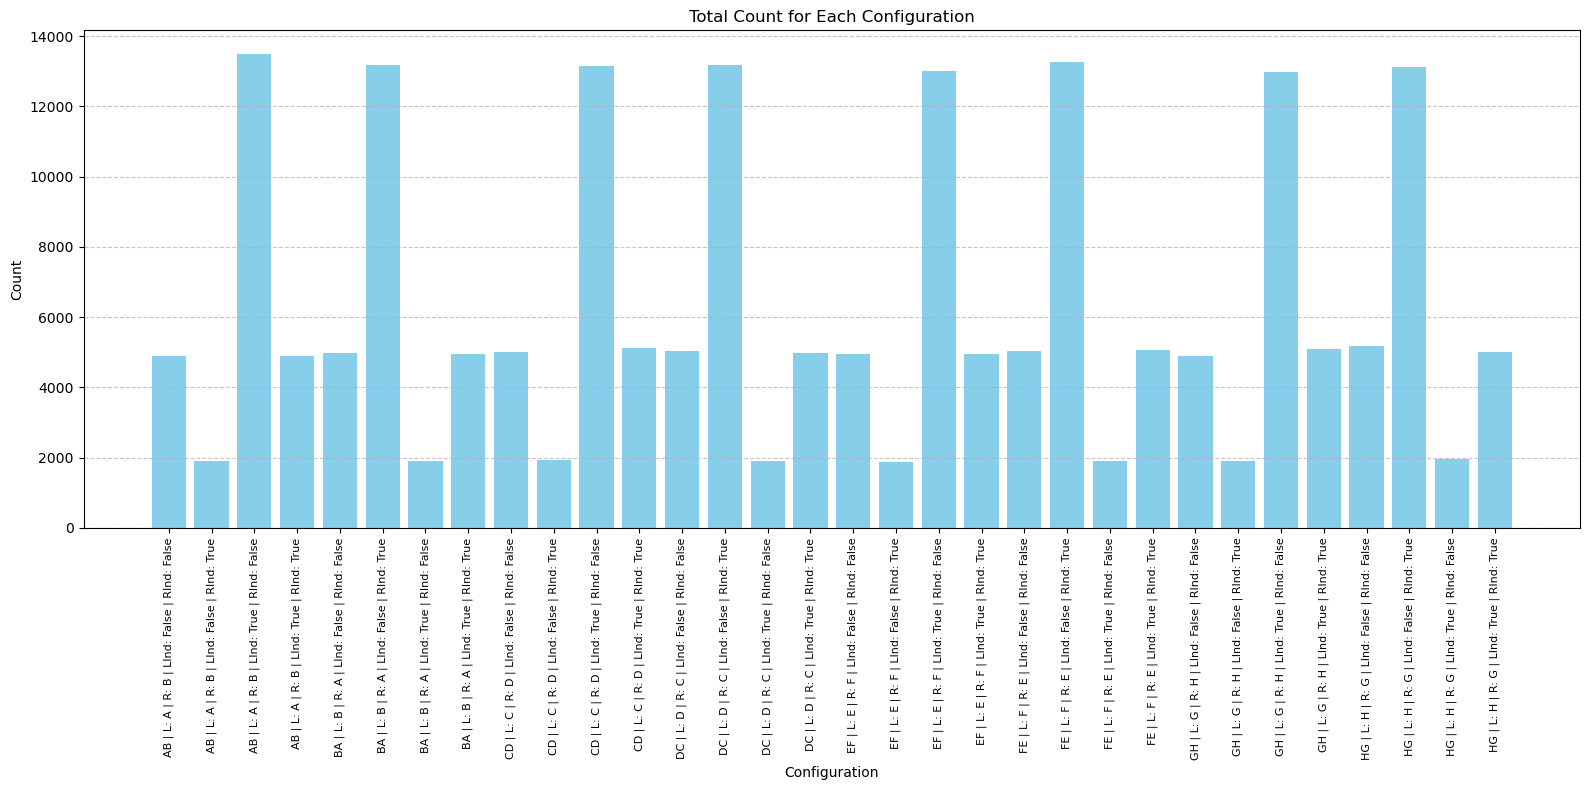

In [7]:
# Create a column for configuration labels for easier plotting
pair_config_counts['configuration'] = (
    pair_config_counts['pair'] + 
    " | L: " + pair_config_counts['lSymbol'] + 
    " | R: " + pair_config_counts['rSymbol'] + 
    " | LInd: " + pair_config_counts['lIndicator'].astype(str) + 
    " | RInd: " + pair_config_counts['rIndicator'].astype(str)
)

# Sort by pair and configuration for better visualization
pair_config_counts = pair_config_counts.sort_values(by=['pair', 'lSymbol', 'rSymbol', 'lIndicator', 'rIndicator'])

# Plot the total counts for each configuration
plt.figure(figsize=(16, 8))
plt.bar(pair_config_counts['configuration'], pair_config_counts['count'], color='skyblue')
plt.xticks(rotation=90, fontsize=8)
plt.title("Total Count for Each Configuration")
plt.xlabel("Configuration")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
obs, _ = env.reset()
for _ in range(50):
    env.render()
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = env.step(action)
    print(f"Action taken: {action}, Reward received: {reward}")

Current pair: D (with indicator 0) vs C (with indicator 0)
Action taken: 1, Reward received: 0
Current pair: D (with indicator 0) vs C (with indicator 1)
Action taken: 1, Reward received: 1
Current pair: B (with indicator 0) vs A (with indicator 1)
Action taken: 1, Reward received: 10
Current pair: H (with indicator 1) vs G (with indicator 1)
Action taken: 1, Reward received: 1
Current pair: F (with indicator 0) vs E (with indicator 1)
Action taken: 1, Reward received: 10
Current pair: F (with indicator 0) vs E (with indicator 1)
Action taken: 1, Reward received: 10
Current pair: A (with indicator 1) vs B (with indicator 0)
Action taken: 0, Reward received: 10
Current pair: F (with indicator 0) vs E (with indicator 1)
Action taken: 1, Reward received: 10
Current pair: A (with indicator 1) vs B (with indicator 0)
Action taken: 0, Reward received: 10
Current pair: E (with indicator 1) vs F (with indicator 0)
Action taken: 0, Reward received: 10
Current pair: F (with indicator 0) vs E (wi

In [24]:
# Switch to Transfer Phase
env.set_transfer_phase(True)
obs, _ = env.reset()

# Test agent in Transfer Phase
for _ in range(500):
    env.render()
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = env.step(action)
    print(f"Action taken: {action}, Reward received: {reward}")

Current pair: H (with indicator 0) vs E (with indicator 1)
Action taken: 1, Reward received: 10
Current pair: G (with indicator 1) vs F (with indicator 0)
Action taken: 0, Reward received: 1
Current pair: A (with indicator 1) vs C (with indicator 1)
Action taken: 0, Reward received: 10
Current pair: D (with indicator 0) vs B (with indicator 0)
Action taken: 0, Reward received: 0
Current pair: F (with indicator 0) vs G (with indicator 1)
Action taken: 1, Reward received: 1
Current pair: G (with indicator 1) vs F (with indicator 0)
Action taken: 0, Reward received: 1
Current pair: D (with indicator 0) vs B (with indicator 1)
Action taken: 1, Reward received: 10
Current pair: D (with indicator 0) vs B (with indicator 1)
Action taken: 1, Reward received: 10
Current pair: H (with indicator 0) vs E (with indicator 1)
Action taken: 1, Reward received: 10
Current pair: B (with indicator 0) vs D (with indicator 1)
Action taken: 1, Reward received: 1
Current pair: E (with indicator 1) vs H (with

In [33]:
# Count the number of times each pair showed up in each configuration
pair_config_counts = logs.groupby(['pair', 'lSymbol', 'rSymbol', 'lIndicator', 'rIndicator']).size().reset_index(name='count')

# Display the results
print(pair_config_counts[pair_config_counts.pair.isin(['FG', 'GF'])])

   pair lSymbol rSymbol  lIndicator  rIndicator  count
44   FG       F       G       False       False      4
45   FG       F       G       False        True      8
46   FG       F       G        True       False      1
47   FG       F       G        True        True      7
48   GF       G       F       False       False      7
49   GF       G       F        True       False     10
50   GF       G       F        True        True      3


In [41]:
logs = pd.DataFrame(env.get_logs())
print(logs[logs.pair.isin(['FG', 'GF'])])

logs[logs.pair.isin(['FG', 'GF'])].to_csv('logsFGGF.csv')

       pair lSymbol rSymbol  lIndicator  rIndicator symbolPicked
200766   FG       F       G        True        True            G
200773   GF       G       F       False       False            G
200791   GF       G       F        True        True            G
200792   GF       G       F        True       False            G
200797   FG       F       G       False        True            G
...     ...     ...     ...         ...         ...          ...
201448   GF       G       F        True       False            G
201451   GF       G       F       False       False            G
201456   FG       F       G       False        True            G
201462   GF       G       F        True       False            G
201464   GF       G       F        True        True            G

[170 rows x 6 columns]
